# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model.

***


Use the below cell to use any include any imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

torch.manual_seed(42)
np.random.seed(42)

## Section 1: Preparing the vocabulary

In [ ]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [ ]:
with open("wordlist.txt",'r') as file:
    words= [line.strip().lower() for line in file]

filter_word = [word for word in words if 3 < len(word) <= WORD_SIZE]

vocab = [word.ljust(WORD_SIZE,'_') for word in filter_word]

<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

<font color='green'>By taking words longer than 3 letters, we can remove function words such as "the" and "and," which do not carry significant semantic weight, helping the model avoid overfitting to them. Additionally, by avoiding words longer than the defined WORD_SIZE, we reduce the model's complexity and enforce a fixed word size, which simplifies computation and makes the process more efficient. </font>


**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [ ]:
def char_to_num(char):
    if(char=="_"):
        return 0
    num=ord(char)-ord("a")+1
    return(num)

def num_to_char(num):
    if(num==0):
        return "-"
    char=chr(num+ord("a")-1)
    return(char)

def word_to_numlist(word):
    num_list = [char_to_num(char) for char in word]
    numlist=torch.tensor(num_list)
    return(numlist)

def numlist_to_word(numlist):
    num_list=numlist.tolist()
    word="".join([num_to_char(num) for num in num_list])
    return(word)

<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

<font color='green'>* Yes, this method assigns a misleading relationship between letters by giving them numbers based on their alphabetical order. By doing this, we incorrectly suggest that letters close to each other have a stronger relationship than those that are farther apart, which is not true in the English alphabet. Letters that are far apart may still have a strong relationship, but this method does not capture that.</font>



<font color='green'>* In the code, the purpose of the embedding layer is to map the input characters to a vector space that can capture more meaningful relationships and richer information. Even though we initially encode the letters in alphabetical order, the embedding layer learns to represent them in a way that captures the true relationships and patterns between the characters, overcoming the limitations of the alphabetical encoding.</font>


<font color='green'>* The purpose of using an embedding layer is to capture the semantic relationships between letters and encode them more meaningfully. Unlike one-hot encoding, which is sparse and high-dimensional, embeddings reduce dimensionality and represent the letters in a dense vector space. These embeddings allow the model to learn how letters are related to each other, which helps the model generalize better and ultimately improves its performance.</font>


## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [ ]:
LEARNING_RATE = 0.005

In [ ]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        #Set the input parameters to self parameters

        self.alphabet_size=alphabet_size
        self.embed_dim=embed_dim
        self.hidden_size=hidden_size
        self.num_layers=num_layers

        #Initialize the layers in the model:
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation

        self.embed=torch.nn.Embedding(alphabet_size,embed_dim)
        self.lstm=torch.nn.LSTMCell(embed_dim,hidden_size)
        self.fc=torch.nn.Linear(hidden_size,alphabet_size)

    #Feedforward
    def forward(self, character, hidden_state, cell_state):

        #Perform feedforward in order
        #1. Embed the input (one charcter represented by a number)
        #2. Feed the embedded output to the LSTM cell
        #3. Feed the LSTM output to the fully connected layer to obtain the output
        #4. return the output, and both the hidden state and cell state from the LSTM cell output

        embedd=self.embed(character)
        (hidden_state,cell_state)=self.lstm(embedd,(hidden_state,cell_state))
        output=self.fc(hidden_state)

        return output, hidden_state, cell_state

    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self):
        h0=torch.zeros(1,self.hidden_size)
        c0=torch.zeros(1,self.hidden_size)
        return (h0, c0)

    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs = 5, batch_size = 100,l_rate=LEARNING_RATE,plot=True):

        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM), you may need to provide the model parameters  and learning rate
        optimizer = torch.optim.Adam(self.parameters(),lr=l_rate)

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        for e in range(epochs):

            random.shuffle(vocab) #Shuffle the vocab list the start of each epoch
            num_iter=len(vocab)//batch_size

            for i in range(num_iter):

                #Set the loss to zero, initialize the optimizer with zero_grad at the beginning of each training cycle.
                loss=0
                optimizer.zero_grad()
                vocab_batch=vocab[i*batch_size:(i+1)*batch_size]

                for word in vocab_batch:

                    #Initialize the hidden state and cell state at the start of each word.
                    hidden_state,cell_state=self.initial_state()

                    #Convert the word into a tensor of number and create input and target from the word
                    word_to_tensor=word_to_numlist(word)
                    #Input will be the first WORD_SIZE - 1 charcters and target is the last WORD_SIZE - 1 charcters
                    inputs=word_to_tensor[:-1]
                    targets=word_to_tensor[1:]

                    #Loop through each character (as a number) in the word
                    for c in range(WORD_SIZE - 1):
                        #Feed the cth character to the model (feedforward) and comput the loss (use cross entropy in torch)
                        output,hidden_state,cell_state=self.forward(inputs[c].unsqueeze(0),hidden_state,cell_state)
                        loss+=torch.nn.functional.cross_entropy(output,targets[c].view(1))


                #Compute the average loss per word in the batch and perform backpropagation (.backward())
                loss=loss/batch_size
                loss.backward()

                #Update model parameters using the optimizer
                optimizer.step()

                #Update the loss_log
                loss_log.append(loss.item())
                #print(i)
                #print("****************************************************")
            if plot:
                print("Epoch: ", e," loss : ",loss)

        #Plot a graph of the variation of the loss.
        if plot:
            plt.plot(loss_log)
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.title('Training Loss Over Time')
            plt.show()

        return loss_log

    #Perform autocmplete given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample):

        #Convert the model into evaluation mode
        self.eval()
        completed_list=[]

        #In the following loop for each sample item initialize hidden and cell states, then predict the remaining characters
        #You will have to convert the output into a softmax (you may use your softmax method from the last project) probability distribution, then use torch.multinomial
        for literal in sample:
            hidden_state,cell_state=self.initial_state()
            literal_tensor=word_to_numlist(literal)

            predict=[]

            for i in range(len(literal_tensor)):
                output,hidden_state,cell_state=self.forward(literal_tensor[i].unsqueeze(0),hidden_state,cell_state)

            for _ in range(WORD_SIZE - len(literal)):
                prob_output = torch.nn.functional.softmax(output, dim=-1)
                char_idx = torch.multinomial(prob_output.squeeze(0), 1).item()
                predict.append(num_to_char(char_idx))

                output, hidden_state, cell_state = self.forward(torch.tensor(char_idx), hidden_state.squeeze(0), cell_state.squeeze(0))

            completed_literal = literal + ''.join(predict)
            completed_list.append(completed_literal)

        return(completed_list)

## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

**Answer** (to write answers edit this cell)

Epoch:  0  loss :  tensor(19.1888, grad_fn=<DivBackward0>)
Epoch:  1  loss :  tensor(16.1545, grad_fn=<DivBackward0>)
Epoch:  2  loss :  tensor(15.0639, grad_fn=<DivBackward0>)
Epoch:  3  loss :  tensor(14.7802, grad_fn=<DivBackward0>)
Epoch:  4  loss :  tensor(14.6587, grad_fn=<DivBackward0>)


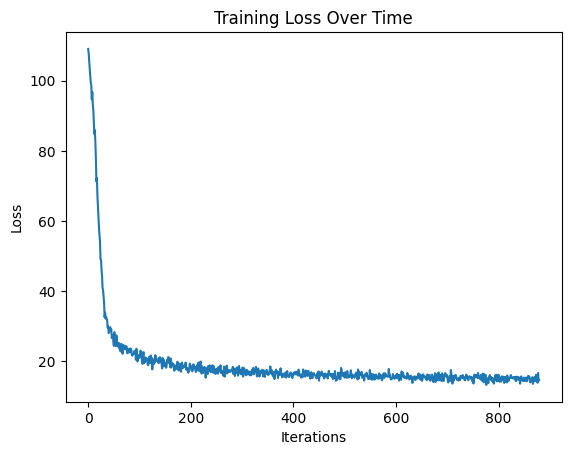

Embed Dim: 100, Hidden Size: 128, Num Layers: 1, Learning Rate: 0.001, Batch Size: 50, Epochs: 5, Final Loss: 14.658687591552734
Epoch:  0  loss :  tensor(17.5014, grad_fn=<DivBackward0>)
Epoch:  1  loss :  tensor(15.7720, grad_fn=<DivBackward0>)
Epoch:  2  loss :  tensor(15.3983, grad_fn=<DivBackward0>)
Epoch:  3  loss :  tensor(16.0522, grad_fn=<DivBackward0>)
Epoch:  4  loss :  tensor(15.6309, grad_fn=<DivBackward0>)
Epoch:  5  loss :  tensor(14.0800, grad_fn=<DivBackward0>)
Epoch:  6  loss :  tensor(13.6535, grad_fn=<DivBackward0>)
Epoch:  7  loss :  tensor(13.3432, grad_fn=<DivBackward0>)
Epoch:  8  loss :  tensor(13.4077, grad_fn=<DivBackward0>)
Epoch:  9  loss :  tensor(13.4714, grad_fn=<DivBackward0>)


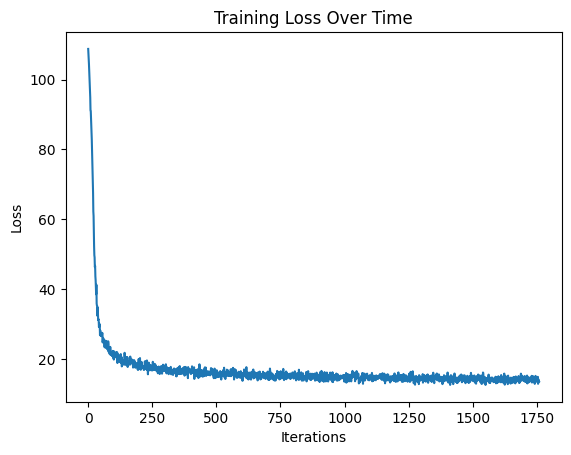

Embed Dim: 100, Hidden Size: 128, Num Layers: 1, Learning Rate: 0.001, Batch Size: 50, Epochs: 10, Final Loss: 13.471421241760254
Epoch:  0  loss :  tensor(17.1244, grad_fn=<DivBackward0>)
Epoch:  1  loss :  tensor(14.8016, grad_fn=<DivBackward0>)
Epoch:  2  loss :  tensor(15.2322, grad_fn=<DivBackward0>)
Epoch:  3  loss :  tensor(15.6849, grad_fn=<DivBackward0>)
Epoch:  4  loss :  tensor(14.7220, grad_fn=<DivBackward0>)


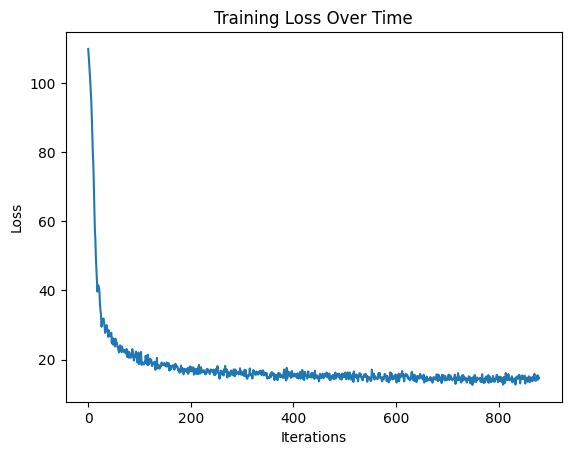

Embed Dim: 100, Hidden Size: 256, Num Layers: 1, Learning Rate: 0.001, Batch Size: 50, Epochs: 5, Final Loss: 14.722001075744629
Epoch:  0  loss :  tensor(16.8274, grad_fn=<DivBackward0>)
Epoch:  1  loss :  tensor(15.8930, grad_fn=<DivBackward0>)
Epoch:  2  loss :  tensor(15.6033, grad_fn=<DivBackward0>)
Epoch:  3  loss :  tensor(14.7607, grad_fn=<DivBackward0>)
Epoch:  4  loss :  tensor(13.9809, grad_fn=<DivBackward0>)
Epoch:  5  loss :  tensor(13.8533, grad_fn=<DivBackward0>)
Epoch:  6  loss :  tensor(13.5819, grad_fn=<DivBackward0>)
Epoch:  7  loss :  tensor(13.4496, grad_fn=<DivBackward0>)
Epoch:  8  loss :  tensor(13.5613, grad_fn=<DivBackward0>)
Epoch:  9  loss :  tensor(13.5757, grad_fn=<DivBackward0>)


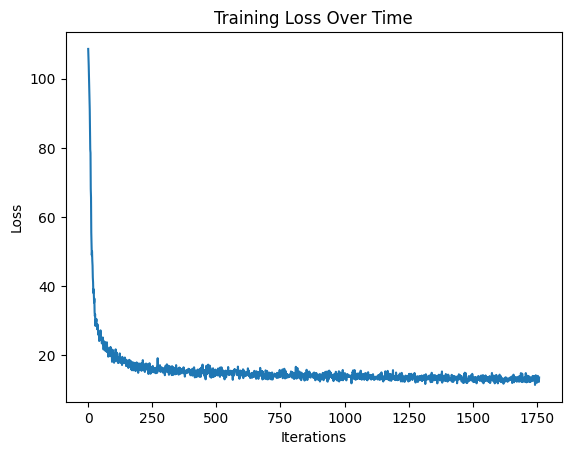

Embed Dim: 100, Hidden Size: 256, Num Layers: 1, Learning Rate: 0.001, Batch Size: 50, Epochs: 10, Final Loss: 13.575693130493164
Best Model Parameters: {'embed_dim': 100, 'hidden_size': 128, 'learning_rate': 0.001, 'batch_size': 50, 'epochs': 10, 'loss_log': [108.82498168945312, 107.41370391845703, 105.6412582397461, 104.40400695800781, 102.52684783935547, 101.13204956054688, 98.37713623046875, 97.63695526123047, 94.90597534179688, 91.17117309570312, 91.08321380615234, 88.98754119873047, 86.67680358886719, 85.52081298828125, 82.80039978027344, 79.63182830810547, 75.51423645019531, 72.55001831054688, 71.0093765258789, 67.62338256835938, 62.246986389160156, 60.97161102294922, 56.232234954833984, 52.312835693359375, 49.67942428588867, 49.086727142333984, 46.300533294677734, 46.648651123046875, 43.6339111328125, 42.541358947753906, 40.67631912231445, 38.499900817871094, 41.226070404052734, 35.86372375488281, 35.29141616821289, 35.161865234375, 32.31883239746094, 34.764644622802734, 32.620

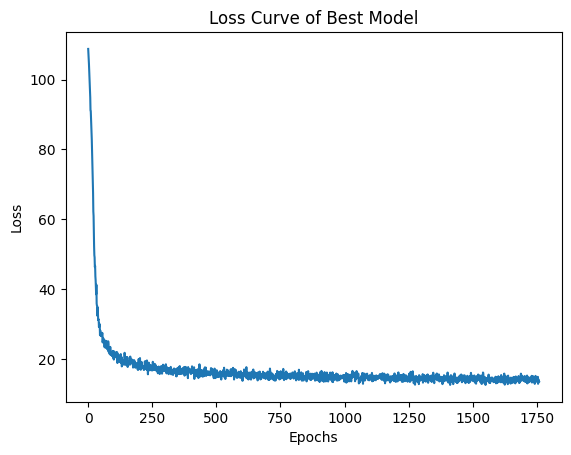

In [ ]:
from itertools import product
import matplotlib.pyplot as plt

# Define the hyperparameter options
embed_dims = [100]
hidden_sizes = [128, 256]
learning_rates = [0.001]
batch_sizes = [50]
epoch_counts = [5,10]

# Initialize an empty list to store results
results = []
min_error = float('inf')  # Set initial minimum error to infinity
best_model_params = None   # To store the best model parameters

# Create all combinations of hyperparameters
param_combinations = product(embed_dims, hidden_sizes, learning_rates, batch_sizes, epoch_counts)

# Iterate over each combination of hyperparameters
for embed_dim, hidden_size, lr, batch_size, epochs in param_combinations:
    #print(f"Training model with embed_dim={embed_dim}, hidden_size={hidden_size}, lr={lr}, batch_size={batch_size}, epochs={epochs}")

    # Initialize the model
    model = autocompleteModel(len(vocab), embed_dim, hidden_size, 1)

    # Train the model and get the loss log
    loss_log = model.trainModel(vocab, epochs=epochs, batch_size=batch_size, l_rate=lr, plot=True)

    # Get the final loss from the loss log
    final_loss = loss_log[-1]  # Final loss after the last epoch

    # Store the results
    results.append({
        'embed_dim': embed_dim,
        'hidden_size': hidden_size,
        'num_layers': 1,  # Assuming num_layers is fixed at 1, adjust if necessary
        'learning_rate': lr,
        'batch_size': batch_size,
        'epochs': epochs,
        'final_loss': final_loss,
        'loss_log': loss_log
    })

    # Print the final loss for the current hyperparameter combination
    print(f"Embed Dim: {embed_dim}, Hidden Size: {hidden_size}, "
          f"Num Layers: 1, Learning Rate: {lr}, "
          f"Batch Size: {batch_size}, Epochs: {epochs}, Final Loss: {final_loss}")

    # Check if the final loss is less than the minimum error
    if final_loss < min_error:
        min_error = final_loss
        best_model_params = {
            'embed_dim': embed_dim,
            'hidden_size': hidden_size,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs,
            'loss_log': loss_log
        }

# After the loop, display the best model parameters and its final loss
print(f"Best Model Parameters: {best_model_params}")
print(f"Minimum Final Loss: {min_error}")

# Optionally, plot the loss curves for the best model
plt.plot(best_model_params['loss_log'])
plt.title('Loss Curve of Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
from itertools import product
import matplotlib.pyplot as plt

# Define the hyperparameter options
embed_dims = [100,64]
hidden_sizes = [128]
learning_rates = [0.001]
batch_sizes = [50]
epoch_counts = [20]

# Initialize an empty list to store results
results = []
min_error = float('inf')  # Set initial minimum error to infinity
best_model_params = None   # To store the best model parameters

# Create all combinations of hyperparameters
param_combinations = product(embed_dims, hidden_sizes, learning_rates, batch_sizes, epoch_counts)

# Iterate over each combination of hyperparameters
for embed_dim, hidden_size, lr, batch_size, epochs in param_combinations:
    #print(f"Training model with embed_dim={embed_dim}, hidden_size={hidden_size}, lr={lr}, batch_size={batch_size}, epochs={epochs}")

    # Initialize the model
    model = autocompleteModel(len(vocab), embed_dim, hidden_size, 1)

    # Train the model and get the loss log
    loss_log = model.trainModel(vocab, epochs=epochs, batch_size=batch_size, l_rate=lr, plot=True)

    # Get the final loss from the loss log
    final_loss = loss_log[-1]  # Final loss after the last epoch

    # Store the results
    results.append({
        'embed_dim': embed_dim,
        'hidden_size': hidden_size,
        'num_layers': 1,  # Assuming num_layers is fixed at 1, adjust if necessary
        'learning_rate': lr,
        'batch_size': batch_size,
        'epochs': epochs,
        'final_loss': final_loss,
        'loss_log': loss_log
    })

    # Print the final loss for the current hyperparameter combination
    print(f"Embed Dim: {embed_dim}, Hidden Size: {hidden_size}, "
          f"Num Layers: 1, Learning Rate: {lr}, "
          f"Batch Size: {batch_size}, Epochs: {epochs}, Final Loss: {final_loss}")

    # Check if the final loss is less than the minimum error
    if final_loss < min_error:
        min_error = final_loss
        best_model_params = {
            'embed_dim': embed_dim,
            'hidden_size': hidden_size,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs,
            'loss_log': loss_log
        }

# After the loop, display the best model parameters and its final loss
print(f"Best Model Parameters: {best_model_params}")
print(f"Minimum Final Loss: {min_error}")

# Optionally, plot the loss curves for the best model
plt.plot(best_model_params['loss_log'])
plt.title('Loss Curve of Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
model.autocomplete( ["univ", "math", "neur", "engin"])